# 03wk-1: 로지스틱 – 로지스틱, BCELoss, Adam

최규빈  
2024-03-13

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/02wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [1]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-xrw8e2pQ1KqKFb-i3lVtsI&si=dDAjAteouM7Y30HU >}}

# 2. Imports

In [2]:
import torch
import matplotlib.pyplot as plt 
import numpy as np

In [3]:
def plot_loss(loss_fn, ax=None, Wstar=[-1,5]):
    w0hat,w1hat =torch.meshgrid(torch.arange(-10,3,0.1),torch.arange(-1,10,0.1),indexing='ij')
    w0hat = w0hat.reshape(-1)
    w1hat = w1hat.reshape(-1)
    def l(w0hat,w1hat):
        yhat = torch.exp(w0hat+w1hat*x)/(1+torch.exp(w0hat+w1hat*x))
        return loss_fn(yhat,y) 
    loss = list(map(l,w0hat,w1hat))
    #---#
    if ax is None: 
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(w0hat,w1hat,loss,s=0.001) 
    ax.scatter(w0hat[::20],w1hat[::20],loss[::20],s=0.1,color='C0') 
    w0star,w1star = np.array(Wstar).reshape(-1)
    ax.scatter(w0star,w1star,l(w0star,w1star),s=200,marker='*',color='red',label=f"W=[{w0star:.1f},{w1star:.1f}]")
    #---#
    ax.elev = 15
    ax.dist = -20
    ax.azim = 75    
    ax.legend()
    ax.set_xlabel(r'$w_0$')  # x축 레이블 설정
    ax.set_ylabel(r'$w_1$')  # y축 레이블 설정
    ax.set_xticks([-10,-5,0])  # x축 틱 간격 설정
    ax.set_yticks([-10,0,10])  # y축 틱 간격 설정

In [311]:
def learn_and_record(net, loss_fn, optimizr):
    yhat_history = [] 
    loss_history = []
    What_history = []
    Whatgrad_history = []
    What_history.append([net[0].bias.data.item(), net[0].weight.data.item()])
    for epoc in range(100): 
        ## step1 
        yhat = net(x)
        ## step2 
        loss = loss_fn(yhat,y)
        ## step3
        loss.backward() 
        ## step4 
        optimizr.step()
        ## record 
        if epoc % 5 ==0: 
            yhat_history.append(yhat.reshape(-1).data.tolist())
            loss_history.append(loss.item())
            What_history.append([net[0].bias.data.item(), net[0].weight.data.item()])
            Whatgrad_history.append([net[0].bias.grad.item(), net[0].weight.grad.item()])
        optimizr.zero_grad() 
        
    return yhat_history, loss_history, What_history, Whatgrad_history

In [525]:
def show_animation(net, loss_fn, optimizr):
    yhat_history,loss_history,What_history,Whatgrad_history = learn_and_record(net,loss_fn,optimizr)
    
    fig = plt.figure(figsize=(8.5,3.5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ## ax1: 왼쪽그림 
    ax1.scatter(x,y,alpha=0.01)
    ax1.scatter(x[0],y[0],color='C0',label=r"observed data = $(x_i,y_i)$")
    ax1.plot(x,v,'--',label=r"prob (true) = $(x_i,\frac{exp(-1+5x_i)}{1+exp(-1+5x_i)})$")    
    line, = ax1.plot(x,yhat_history[0],'--',label=r"prob (estimated) = $(x_i,\hat{y}_i)$") 
    ax1.legend()
    ## ax2: 오른쪽그림 
    plot_loss(loss_fn,ax2)
    ax2.scatter(np.array(What_history)[0,0],np.array(What_history)[0,1],loss_history[0],color='blue',s=200,marker='*')    
    def animate(epoc):
        line.set_ydata(yhat_history[epoc])
        w0hat = np.array(What_history)[epoc,0]
        w1hat = np.array(What_history)[epoc,1]
        w0hatgrad = np.array(Whatgrad_history)[epoc,0]
        w1hatgrad = np.array(Whatgrad_history)[epoc,1]
        ax2.scatter(w0hat,w1hat,loss_history[epoc],color='grey')
        ax2.set_title(f"What.grad=[{w0hatgrad:.4f},{w1hatgrad:.4f}]",y=0.8)
        fig.suptitle(f"epoch={epoc*5} // What=[{w0hat:.2f},{w1hat:.2f}] // Loss={loss_fn.__class__.__name__} // Opt={optimizr.__class__.__name__}")
        return line
    ani = animation.FuncAnimation(fig, animate, frames=20)    
    plt.close()
    return ani

In [526]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

# 3. ToyData (1)

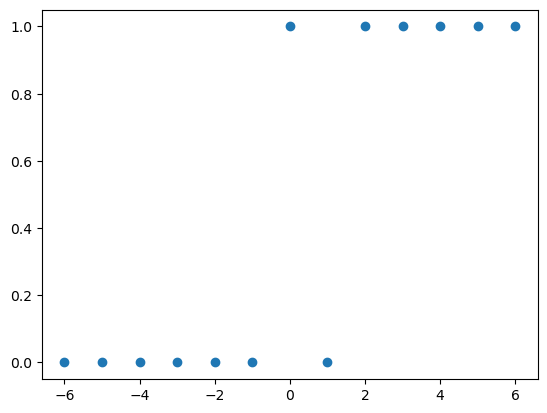

In [527]:
x = torch.tensor([-6,-5,-4,-3,-2,-1, 0, 1, 2, 3, 4, 5, 6.0]).reshape(-1,1)
y = torch.tensor([ 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]).reshape(-1,1)
plt.plot(x,y,'o')

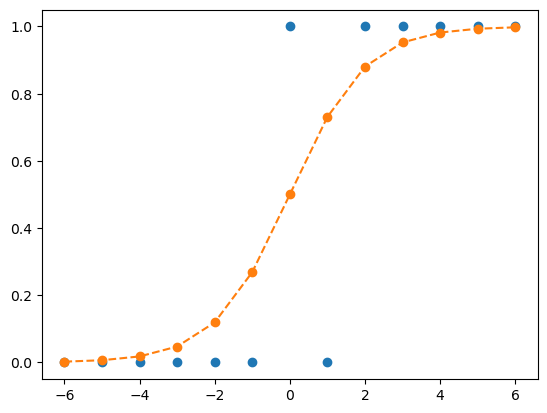

In [528]:
plt.plot(x,y,'o')
plt.plot(x,torch.exp(x)/(1+torch.exp(x)),'o--')

# 4. ToyData (2)

In [529]:
x = torch.linspace(-1,1,2000).reshape(2000,1)
w0 = -1
w1 = 5
u = w0 + x*w1 # 선형변환이네?
v = torch.exp(u) / (1+torch.exp(u)) 
y = torch.bernoulli(v)

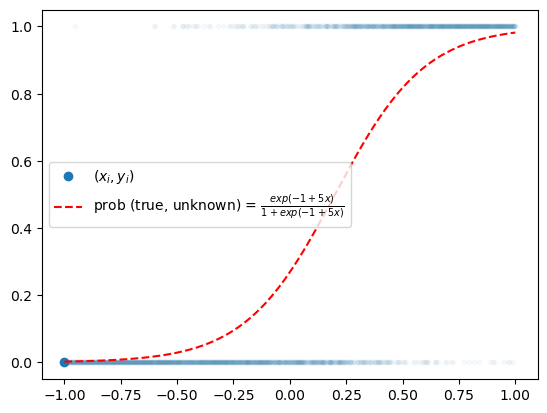

In [530]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,v,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.legend()

우리의 목적: $x_i$가 들어가면 빨간곡선 $\hat{y}_i$의 값을 만들어주는
mapping을 학습해보자.

## Step1: net 설계 (모델링)

`-` 최초의 곡선을 그려보자. ($net: x \to yhat$ 을 수행하는 네트워크를
설계해보자는 의미)

In [531]:
w0hat = -0.8
w1hat = -0.3

In [532]:
def sigmoid(x):
    return torch.exp(x)/(1+torch.exp(x))

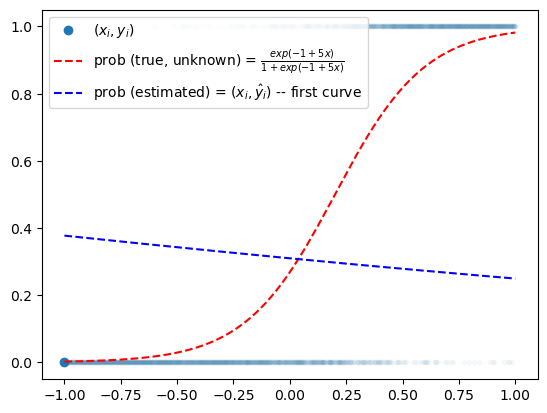

In [533]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,v,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.plot(x,sigmoid(w0hat + w1hat*x),'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve")
plt.legend()

`-` `w0hat + w1hat*x` 이 부분을 `torch.nn.Linear(bias = False)`로 구현

In [534]:
X = torch.concat([torch.ones(2000).reshape(-1,1),x],axis=1)
l1 = torch.nn.Linear(in_features=2, out_features=1, bias = False)
l1.weight

In [535]:
l1.weight.data = torch.tensor([[-0.8,  -0.3]])

In [536]:
l1(X), w0hat + w1hat*x # 똑같죠

`-` `w0hat + w1hat*x` 이 부분을 `torch.nn.Linear(bias = True)`로 구현

In [537]:
#X = torch.concat([torch.ones(2000).reshape(-1,1),x],axis=1)
l1 = torch.nn.Linear(in_features=1, out_features=1)
l1.weight, l1.bias

In [538]:
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])

In [539]:
l1(x), w0hat + w1hat*x # 이것도 똑같죠!

`-` 내가만든 sigmoid 대신에 토치에서 제공하는 sigmoid 사용

In [540]:
a1 = torch.nn.Sigmoid()

In [541]:
sigmoid(l1(x)), a1(l1(x)) # 똑같아요

`-` 지금까지의 구현 확인

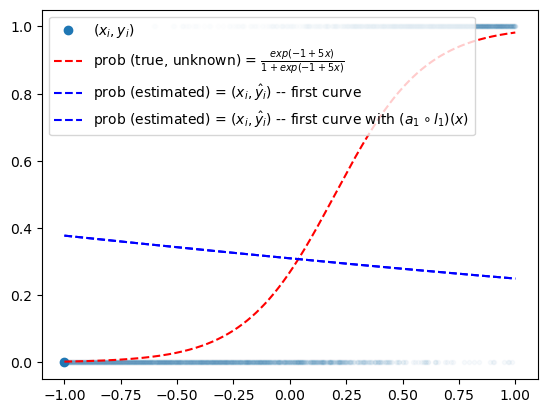

In [542]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,v,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.plot(x,sigmoid(w0hat + w1hat*x),'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve")
plt.plot(x,a1(l1(x)).data,'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve with $(a_1 \circ l_1)(x)$")
plt.legend()

`-` 관찰: 지금 아래의 구조이다.

$${\boldsymbol x} \overset{l_1}{\to} {\boldsymbol u} \overset{a_1}{\to} {\boldsymbol v} = \hat{\boldsymbol y}$$

`-` 소망: 함수 $l_1, a_1$ 의 합성을 하나로 묶어서

$$(a_1\circ l_1)({\boldsymbol x}) := net({\boldsymbol x})$$

이러한 기능을 하는 하나의 함수 $net$을 만들 수 없을까?

In [543]:
net = torch.nn.Sequential(l1,a1) #l1을 취하고 그다음에 a1을 취하라는 의미

In [544]:
net(x), a1(l1(x)), sigmoid(w0hat+ w1hat*x)

`-` net 살펴보기: 초보버전 – “파이토치 30일만에 완성하기” 이런책에 보면
내용이 나올지도?

In [545]:
net

-   처음에는 선형변환하고, 그담에는 Sigmoid를 수행하라는 의미

`-` net 살펴보기: 고수버전 – 책 안보고 코딩배우기

In [546]:
set(dir(net)) & {'__call__', '__getitem__'}

-   좋은거 가지고 있네 ㅎㅎ
-   callable 이면서 subscriptable 오브젝트..

In [547]:
lst = [11,22,33]
lst.__getitem__(-1) # lst[-1]

In [548]:
sigmoid.__call__(x) # sigmoid(x)

In [549]:
sigmoid[0] # 난 스크립터블 하지 않은걸? (= 난 리스트처럼 인덱싱 못해요)

In [550]:
lst(x)# 난 컬러블하지 않은걸? (= 난 함수처럼 입력을 받고 출력을 주는 일은 못해요)

In [551]:
net(x) # 컬러블이면서

In [552]:
net[0],net[1] # 섭스크립터블

In [553]:
_l1, _a1 = net # 언패킹!! (섭스크립터블하니까..)

In [554]:
_l1.weight, _l1.bias # 내가 설정한 웨이트도 그대로 들어가있음

## Step 1~4

In [555]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1),
    torch.nn.Sigmoid()
)
l1, a1 = net # 네트워크는 섭스크립터블 오브젝트이니까..
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
#loss_fn = torch.nn.MSELoss() # -- 이 코드 일단 쓰지 않을게여
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)
#---#
for epoc in range(100):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = torch.mean((y-yhat)**2)
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

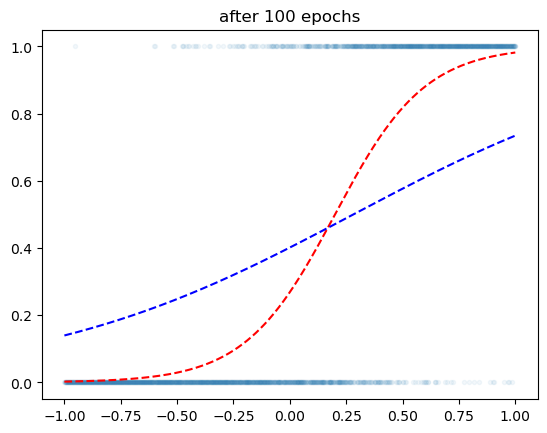

In [556]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

In [557]:
for epoc in range(4900):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = torch.mean((y-yhat)**2)
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

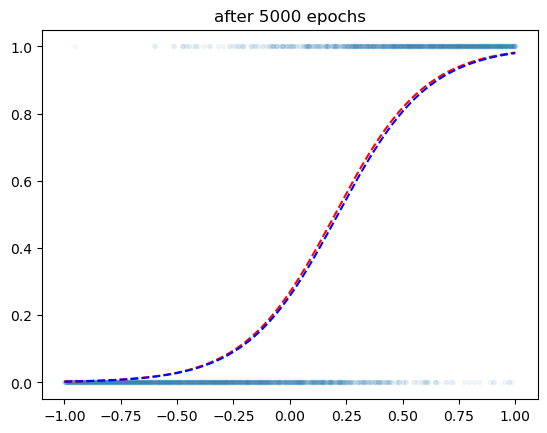

In [558]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 5000 epochs')

성공했나?

# 5. 학습과정 시각화 및 문제인식

## A. 좋은 초기값

In [559]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## B. 가능성 있는 초기값

In [560]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## C. 최악의 초기값

In [561]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

해결하는 접근법:

-   컴공스타일: 에폭을 늘려볼까?
-   산공스타일: 옵티마이저를 바꿔볼까?
-   통계스타일: Loss를 바꿔볼까?

# 6. 손실함수의 개선

## A. BCE Loss를 사용하여 학습

`-` BCE loss라는게 있음.

-   <https://en.wikipedia.org/wiki/Cross-entropy>

In [562]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1),
    torch.nn.Sigmoid()
)
l1, a1 = net # 네트워크는 섭스크립터블 오브젝트이니까..
l1.weight.data = torch.tensor([[-0.3467]])
l1.bias.data = torch.tensor([-0.8470])
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)
#---#
for epoc in range(100):
    ## 1
    yhat = net(x) 
    ## 2 
    #loss = torch.mean((y-yhat)**2)
    loss = -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

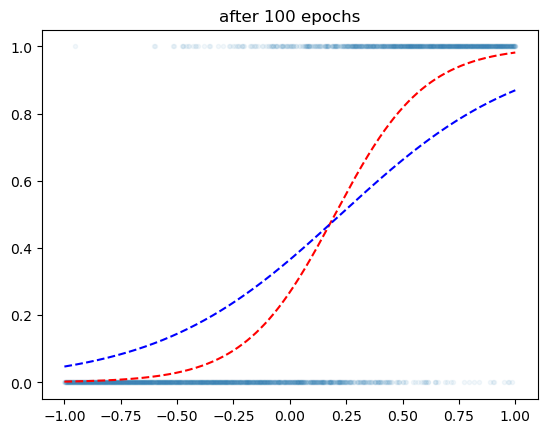

In [563]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

같은 100 에폭인데 훨씬 잘맞춤..

`-` loss수식을 못외우겠다면?

In [564]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1),
    torch.nn.Sigmoid()
)
l1, a1 = net # 네트워크는 섭스크립터블 오브젝트이니까..
l1.weight.data = torch.tensor([[-0.3467]])
l1.bias.data = torch.tensor([-0.8470])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)
#---#
for epoc in range(100):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y) # yhat부터 써야함
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

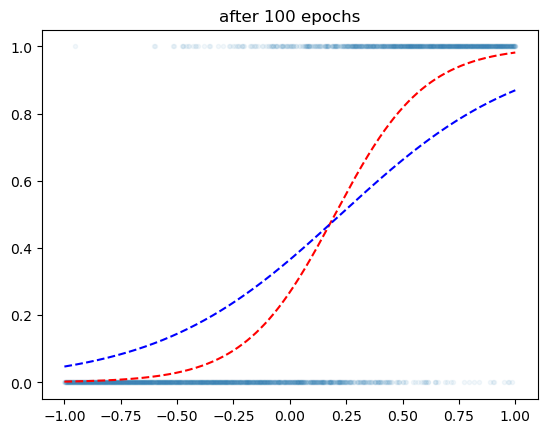

In [565]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

## B. Loss Function 시각화

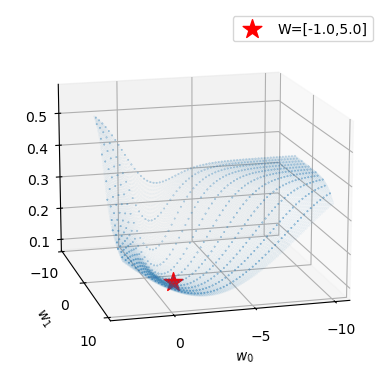

In [566]:
plot_loss(torch.nn.MSELoss())

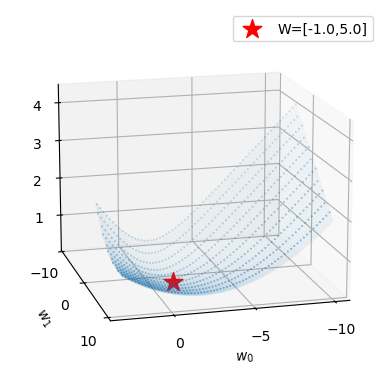

In [567]:
plot_loss(torch.nn.BCELoss())

`-` 비교해보자.

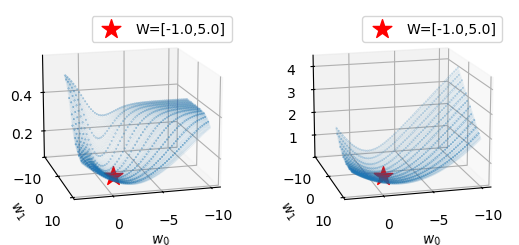

In [568]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
plot_loss(torch.nn.MSELoss(),ax1)
plot_loss(torch.nn.BCELoss(),ax2)

## C. 학습과정 시각화 – 좋은 초기값

`-` MSELoss

In [569]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` BCELoss

In [570]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## D. 학습과정 시각화 – 가능성 있는 초기값

`-` MSELoss

In [571]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` BCELoss

In [572]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## E. 학습과정 시각화 – 최악의 초기값

`-` MSELoss

In [573]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` BCELoss

In [574]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

# 7. 옵티마이저의 개선

## C. 학습과정 시각화 – 좋은 초기값

`-` MSELoss + SGD

In [575]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-0.8470])
# net[0].weight.data = torch.tensor([[-0.3467]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [576]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8470])
net[0].weight.data = torch.tensor([[-0.3467]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## D. 학습과정 시각화 – 가능성 있는 초기값

`-` MSELoss + SGD

In [577]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-3.0])
# net[0].weight.data = torch.tensor([[-1.0]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [578]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## E. 학습과정 시각화 – 최악의 초기값

`-` MSELoss + SGD

In [579]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-10.0])
# net[0].weight.data = torch.tensor([[-1.0]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 
# #---#
# show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [580]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)